Ce notebook est un essai, régulièrement mis à jour, sur le challenge le plus populaire du site **kaggle** : *Titanic: Machine Learning from Disaster*.

C'est un très bon point de départ pour une analyse de données, et des premiers jeux d'apprentissage statistique et de machine learning.

Ce notebook a été inspiré après lecture d'un certain nombre sur le sujet, en particulier ceux de Meg Risdal, Manav Sehgal et de Rifky Ahmad Saputra.

Voici un résumé rapide des notions apprises tout au long de la réalisation de ce Notebook :

- Manipulation approfondie de la bibliothèque `Pandas`
- Utilisation des bibliothèques `seaborn` et `statsmodel`, bien pratiques pour des statistiques descriptives et des modèles basiques (linéaire, logistique)
- Gérer les valeurs aberrantes (outlier) 
- One Hot Encoding (OHE) et dummy variables

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [67]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
full_data = [train_data, test_data]

In [68]:
%%capture
# Analyse de données
import pandas as pd
import numpy as np

# Dataviz
import seaborn as sns
sns.distributions._has_statsmodels = False # To handle RuntimeError: Selected KDE bandwidth is 0.
import matplotlib.pyplot as plt
%pylab inline

# Stats
import statsmodels
#import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
# from scipy.stats import poisson
from scipy.stats import expon

# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neural_network import MLPClassifier

In [69]:
from google.colab import files
uploaded = files.upload()

# Exploration des données

In [70]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [71]:
# La fonction copie génère des messages d'alertes lors de la manipulation. On l'évite donc pour l'instant.

# train = train_data.copy()
# test = test_data.copy()

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

On va tout d'abord regarder les données dans l'ensemble.

In [72]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


On dispose donc de 12 variables :


1.   `PassengerId` : le numéro d'identification des passagers, jouant ici le rôle de clé primaire dans la base de données;
2.   `Survived` : ue variable binaire, qui nous dit si $1$, le passager a survécu, $0$ sinon;
3.   `Pclass` : la classe du passager (première, seconde, ou troisième);
4.   `Name` : le nom du passager, avec son titre;
5.   `Sex` : le genre du passager `male`ou `female`;
6.   `Age` : l'age du passager;
7.   `SibSp` : le nombre de "Siblings" que le passager possède à bord (frères, soeurs, cousins, épouse, époux, etc...);
8.   `Parch` : le nombre d'enfants pour les parents ou inversement (parents pour les enfants), à bord.
9.   `Ticket` : le numéro de ticket du passager, ce champ comporte parfois des lettres, parfois des chiffres, parfois les deux;
10.  `Fare` : le prix payé par le passager;
11.  `Cabin` : la cabine dans laquelle se trouvait le passager,
12.  `Embarked` : une lettre qui nous dit où le passager à embarqué.

On peut déjà supposer que `PassengerId` ne nous sera pas utile, et que certaines données telles que `Cabin` ou `Ticket` joueront un rôle minime dans la modélisation, si utilisées de manières brutes.
On peut aussi faire les suppositions classiques qui nous viennent d'à prioris (le film par exemple) et qu'on vérifiera par la suite, telles que :


*   les passagers ont une chance réduite de survivre plus leur classe est basse;
*   les femmes et les enfants ont plus de chance de survivre (fameux "les femmes et les enfants d'abord");
*   les passagers les plus jeunes ont plus de chance de survivre.


In [74]:
print(train.info())
print('\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   P

On constate tout d'abord que les variables `Age`, `Cabin` et `Embarked` ne sont pas complètes, ainsi que `Fare`à qui il manque une ligne dans la base de test. Nous sommes en présence d'un data set assez petit et que l'on doit exploiter au maximum (c'est tout de même un challenge, évalué sur la perfomance du modèle de prédiction, toute donnée est bonne à prendre).

On va donc se proposer de "remplir" de différentes manières le data set. Avant d'essayer d'en extraire le maximum d'informations possibles.

Mais on va en premier lieu parcourir un peu les données, et regarder des statistiques purement descriptives sur la base, pour avoir une idée de la pertinence de certaines données, ainsi que des pistes qu'on pourrait utiliser plus tard :

In [75]:
# Résumé des valeurs quantitatives

train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Choses à noter par rapport au tableau ci dessus :


*   environ 38.4% des passagers (base de test) ont survécus;
*   l'âge moyen est de 30 ans, l'âge médian est de 28 ans;
*   Le prix moyen est de 32\$, le prix médian est de 14\$, plus de billet "chers", cela peut paraître normal;
*   beaucoup de gens sont considérés comme "seuls", avec un nombre de siblings et de enfants/parents médian à 0.

In [76]:
# Résumé des valeurs qualitatives

train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Mamee, Mr. Hanna",male,347082,G6,S
freq,1,577,7,4,644


Choses à noter par rapport au tableau ci dessus :

*   que des noms uniques;
*   577/889 = 64.8% d'hommes à bord;
*   peu de données sur les cabines, un certain nombre de doublons (non surprenant, plusieurs personnes peuvent partager la même cabine);
*   quelques données manquantes sur les lieux d'embarquement.

# Statistiques descriptives et régression linéaire (rapide)

Avant d'effectuer des statistiques descriptives, on effectue rapidement une manipulation que l'on pourra juger plus ou moins utile dans le but de rendre un minimum lisible la colone `Cabin`. On abanonne pour l'instant la colone `Ticket`. On ne gardera donc que la lettre (et pas le numéro) donnant donc une indication sur le pont auquel se trouvait le passager.

In [77]:
# On récupère uniquement le premier caractère de la colonne Cabin

train['Cabin'] = train['Cabin'].str.get(0)
test['Cabin'] = test['Cabin'].str.get(0)

## Statistiques descriptives

Le travail sur les statistiques descriptives reste à améliorer, il fera l'objet d'une future modification.

On va maintenant, pour des questions de manipulations avec la bibliothèque `seaborn` séparer le training set en deux parties, les valeurs numériques et les valeurs catégoriques.

In [78]:
# On sépar le dataset en deux parties : les valeurs numériques, et les valeurs texte
num_data = train[['Age', 'SibSp', 'Parch', 'Fare']]
cat_data = train[['Survived', 'Pclass', 'Sex', 'Cabin', 'Embarked']]

La suite se passe en trois étapes (choisies assez arbitrairement je le concède) :
* On regarde les distributions et la corrélation des variables numériques
* On regarde la distribution ("proportions" si l'on veut) des varaibles qualitatives
* On commence à regarder certaines variables conditionnellement à la varaible à expliquer (le but est de "jouer" avec les variables, remarquer certaines choses, avoir une bonne impression du dataset, etc...)

On utilise ici la fonction `distplot` de la bibliothèque `seaborn`, elle permet d'avoir un histogramme et une idée rapide de la distribution des données numériques (et mettre en 3 lignes une pseudo fonction de répartition ça fait toujours stylé), pour plus d'infos : https://seaborn.pydata.org/generated/seaborn.distplot.html

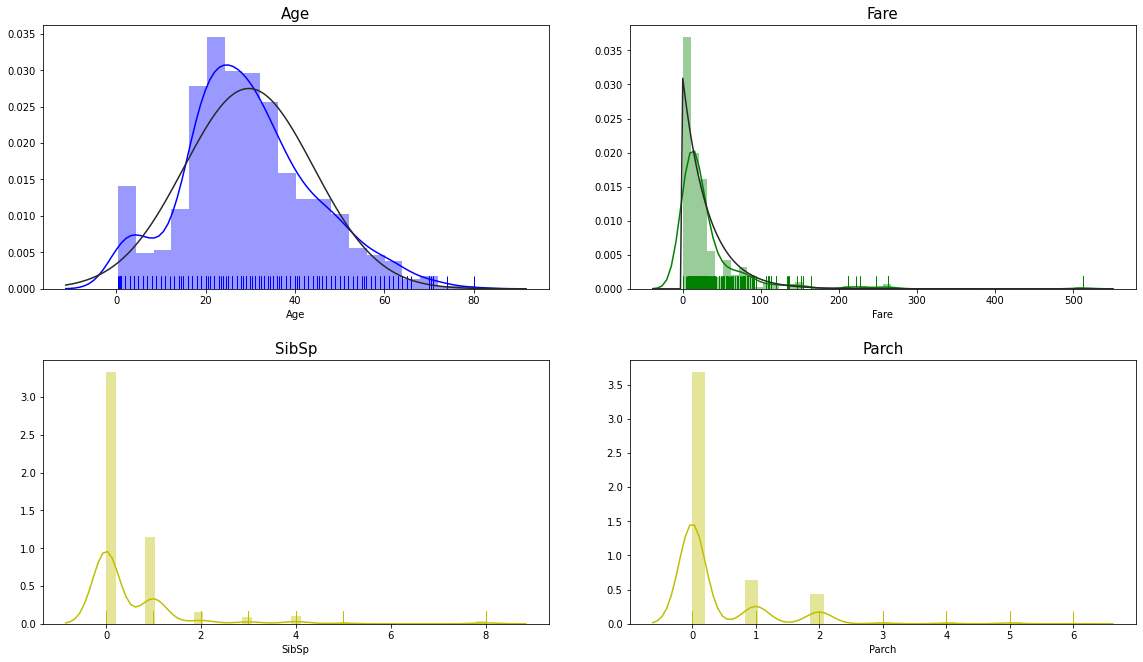

In [79]:
fig, ax = plt.subplots(2, 2 ,figsize = [17,10])
fig.tight_layout(pad=5.0)

sns.distplot(ax = ax[0, 0], a = num_data['Age'].dropna(), rug = True, color = 'b', fit = norm)
ax[0, 0].set_title('Age', fontsize = 15)

sns.distplot(ax = ax[0, 1], a = num_data['Fare'].dropna(), rug = True, color = 'g', fit = expon)
ax[0, 1].set_title('Fare', fontsize = 15)

sns.distplot(ax = ax[1, 0], a = num_data['SibSp'].dropna(), rug = True, color = 'y')
ax[1, 0].set_title('SibSp', fontsize = 15)

sns.distplot(ax = ax[1, 1], a = num_data['Parch'].dropna(), rug = True, color = 'y')
ax[1, 1].set_title('Parch', fontsize = 15)

plt.show()

Remarques sur les graphiques ci dessus, si l'on voudrait plus tard utiliser la distribution de ces variables :
* l'age semble avoir une jolie distribution normale;
* de même pour le prix du ticket avec une loi exponentielle;
* `SibSp` et `Parch`, semblent elles suivre une loi de poisson, cela est purement hypothétique.

On utilise ici la fonction `heatmap` de `sns`, elle permet de notamment regarder les coorélations entre les différentes variables, et de vérifier qu'elles ne soient pas colinéaires entre elles.

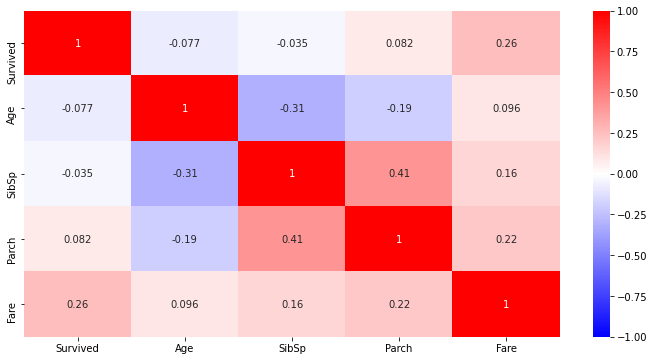

In [80]:
# heatmap data numeric, to prevent multicolinearity

heatmapdata = train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']]

correl_mat = heatmapdata.corr()
fig, ax = plt.subplots(figsize = [12,6])
sns.heatmap(data = correl_mat, vmax = 1, vmin = -1, annot = True, cmap = 'bwr')
plt.show()

Remarques sur le graphique ci-dessus : Pas de corrélation apparente, toutes les variables numériques semblent donc pertinentes et à conserver.

On va alors s'intéresser aux variables catégoriques et regarder simplement leur proportions dans le dataset :

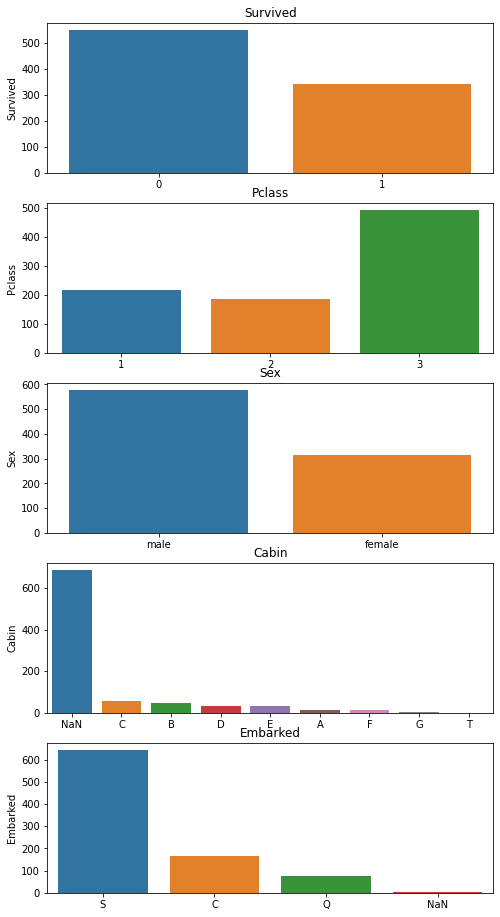

In [81]:
fig, ax = plt.subplots(cat_data.shape[1], 1, figsize = [8,16])
for i, n in enumerate(cat_data):
    sns.barplot(ax = ax[i], x = cat_data[n].fillna('NaN').value_counts().index, y = cat_data[n].fillna('NaN').value_counts())
    ax[i].set_title(n)
plt.show()

Remarques sur les graphiques ci-dessus : On n'apprend pas vraiment quelque chose de plus que ce qui a été vu dans l'exploration des données, on retiendra surtout le fait que la variable `Cabin` ne ressemble pas à grand chose avec beaucoup de `NaN` et ne semble pas pertinente pour nous donner de l'information.

On va alors s'intéresser à la relations entre certaines variables (`Pclass`, `Sex`, `SibSp`, `Parch`) et la variable d'intéret `Survivied` :

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


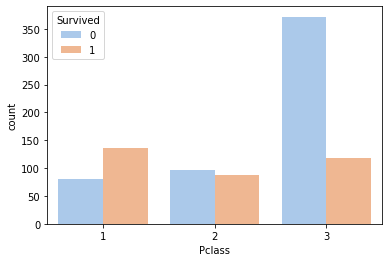

In [82]:
print(train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
sns.countplot(x="Pclass", hue="Survived", data=train_data, palette='pastel')

On remarque tout d'abord que le mythe de la "première classe" et "troisième classe" est véridique, 63% des passagers de première classe ont survécus contre un petit 25% pour la troisième classe.

      Sex  Survived
0  female  0.742038
1    male  0.188908


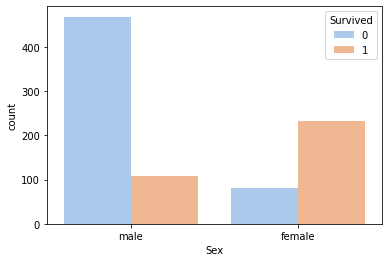

In [83]:
print(train_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))
sns.countplot(x="Sex", hue="Survived", data=train_data, palette='pastel')

Les femmes ont aussi un lourd avantage, presque 75% pour les femmes contre un faible 19% pour les hommes.

La classe et le sexe semblent donc être des variables très significatives nous vérifieront ça par la suite avec un modèle linéaire simple.

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


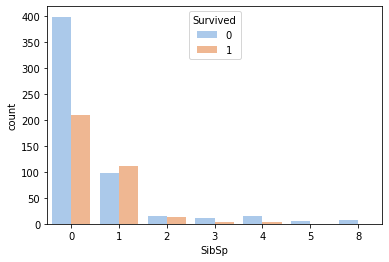

In [84]:
print(train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
sns.countplot(x="SibSp", hue="Survived", data=train_data, palette='pastel')

Il est ici plus compliqué d'observer une tendance, il semblerait que les chances de survies soient meilleures avec 1 ou 2 siblings, mais cela reste flou... Il y a peu de données pour les grandes valeurs (> 3) et beaucop pour le 0 (gens seuls) qui semble être assez révélateur d'une mauvaise posture quant à la surive (35 %). 

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


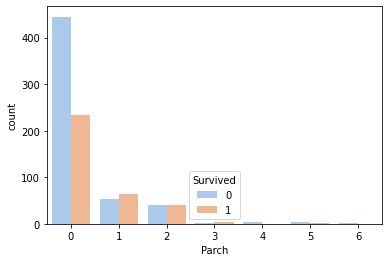

In [85]:
print(train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
sns.countplot(x="Parch", hue="Survived", data=train_data, palette = 'pastel')

De même pour les enfants/parents, peu de tendance semble se dégager, la taille des données chute exponentiellement. 

On pourrait continuer un certain temps comme cela, augmentant les intéractions entre les variables, mais on va préférer une approche un peu plus mathématique à la question. On retiendra que :



*   Comme prévu, `Pclass`, `Sex` et `Age` sont des variables qui *semblent* significatives;
*   Il est difficile de tirer une tendance des autres.

Mais aussi que les variables à compléter sont : `Age`, `Fare` et `Embarked`. On laisse pour plus tard le travail sur `Name` et `Cabin` pour l'exploitation de ces données.

## Régression linéaire (rapide)

On se propose alors maintenant, comme tout bon Data Scientist, de regarder assez rapidement les données via un Modèle Linéaire standard, pour savoir si nos suppositions de pertinence des variables effectuée ci-dessus s'avèrent correctes, et quelles variables sont peut significatives, et seront donc sujet à travail.
On retire d'ores et déjà la variable `Name`, étant donné qu'elle ne contient que des varaibles différentes, ainsi que la classe `PassengerId` pour des raisons évidentes, et la classe . Le modèle va tout seul implémenter des valeurs chiffrées pour les classe de type `str`.

On notera que l'absence de certaines valeurs ne posera pas de problèmes au modèle, et on les supposera sans conséquences sur la significaivité des variables. On les completera juste après dans une partie appropriée.

In [86]:
model = smf.ols("Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked", data = train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     58.84
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           2.73e-73
Time:                        08:41:55   Log-Likelihood:                -321.06
No. Observations:                 712   AIC:                             660.1
Df Residuals:                     703   BIC:                             701.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4031      0.082     17.214

Sur cette première régression, il est utile de noter les variables significatives (p-value < 0.05) : 

*   `Sex`
*   `Pclass`
*   `Age`
*   `SibSp`

Celles qui peuvent être jugées non significatives (p-value élevée, proche ou supérieur à 0.1) sont donc :

*   `Parch`
*   `Fare`
*   `Embarked`

On notera le score beaucoup plus bas pour `Embarked[T.S]`, ce qui semble normal, le S étant beaucoup plus prépondérant (72% de l'ensemble).

On se propose alors, d'effectuer une seconde régression linéaire uniquement sur les variables jugées significatives sur cette première régression :

In [87]:
model_2 = smf.ols("Survived ~ Pclass + Sex + Age + SibSp", data = train).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     118.0
Date:                Sun, 23 Aug 2020   Prob (F-statistic):           3.81e-77
Time:                        08:41:55   Log-Likelihood:                -323.22
No. Observations:                 714   AIC:                             656.4
Df Residuals:                     709   BIC:                             679.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.3966      0.066     21.287      

Toute les p-values sont ici largement inférieures à 0.05, on les considère donc toutes comme significatives.

On peut donc commencer le travail sur les données.

# Pré-processing (les 4 'C')

Appris dans un très beau Notebook, plus que complet (non cité plus haut, celui de LD Freeman), cela permet de se rappeler plus que facilement que faire lors du pré-procesing :

- Completing : Compléter le dataset qui comporte probablement des valeurs manquantes
- Cleaning : Nettoyer le dataset, chercher les valeurs aberrantes notamment
- Creating : Créer de nouvelles variables qui semblent pertinentes et utiles pour la modélisation
- Converting : Normaliser, Scaler, Centrer toutes les varaibles numériques (pas forcément celles qui servent de 'compteur' attention)

## Complétion (Completing)

In [88]:
# On insère une colonne 'Survived' dans le set de test (remplie de -1)

test.insert(1, 'Survived', -1)

# test.info()

# On regarde quelles colonnes présentent des valeurs manquantes dans les deux datasets

print('Train :\n',train.isnull().sum())
print('\n')
print('Test :\n', test.isnull().sum())

Train :
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Test :
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


La bibliothèque Pandas possède la fonction `Dataframe[].fillna()` qui permet de remplir suivant certaines méthodes des valeurs `NaN` dans un dataset (plus à : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [89]:
# On remplit les valeurs manquantes par les médiandes pour l'age et pour le prix du ticket, par le mode pour le lieux d'embarcation

train['Age'].fillna(train['Age'].median(), inplace = True)
test['Age'].fillna(train['Age'].median(), inplace = True)

train['Fare'].fillna(train['Fare'].median(), inplace = True)
test['Fare'].fillna(train['Fare'].median(), inplace = True)

train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace = True)

# On drop alors les lignes ne présentant pas de valeurs pour Embarked

# On décide pour l'instant de drop aussi la colonne Cabin

train.drop(['Cabin'], axis = 1, inplace = True)
test.drop(['Cabin'], axis = 1, inplace = True)

In [90]:
# On vérifie que l'on ne possède plus de valeurs nulles dans le dataset

print('Train :\n',train.isnull().sum())
print('\n')
print('Test :\n', test.isnull().sum())

Train :
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Test :
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


## Nettoyage (Cleaning)

On supprime juste les valeurs aberrantes comme expliqué ici : https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [91]:
# Gérer les valeurs aberrantes

q1 = train['Age'].quantile(0.25)
q3 = train['Age'].quantile(0.75)
iqr = q3-q1
train = train[~((train['Age'] < (q1 - 1.5 * iqr)) | (train['Age'] > (q3+1.5*iqr)))]

q1=train['Fare'].quantile(0.25)
q3 = train['Fare'].quantile(0.75)
iqr = q3-q1
train = train[~((train['Fare'] < q1 - 1.5 * iqr) | (train['Fare'] > (q3 + 1.5 * iqr)))]

## Création (Creating)

On se demande ici quelles variables supplémentaires nous allons pouvoir créer, qui vont nous aider à obtenir la meilleure prédiction possible. On s'arrêtera sur les variables suivantes :

1. Les deux variables `Family Survived` et `Family Died` dont la construction est exposée ci-dessous via une varialbe `Last Name`
2. La variable `Size_Family` qui représente la taille de la famille du passager
3. La variable `Title` qui utilise aussi le nom du passager et récupère son titre.

Le code suivant vient de Ken Jee (et sa très complète vidéo youtube : https://www.youtube.com/watch?v=I3FBJdiExcg&t=1477s). L'idée est la suivante : rajouter deux colonnes, `FamilyDied` et `FamilySurvived`, qui indiqueront donc le nombre de membres de la famille du passager ayant survécus (ou non). La mise en place se fait comme suit :

- On récupère les noms de familles des passagers;
- On merge les deux datasets (pour avoir toutes les données si les familles sont séparées dans les deux jeux de données);
- On va ensuite en itérant sur le jeux de données, regarder le nombre de morts et de survivants dans la famille.

Il faut cependant légèrement se pencher sur la méthode de décompte : on a ajouté plus haut une varaible `Survived` à la base de test, ayant pour valeur (-1). Cela est donc pris en compte lors du calcul.
On prendra un rapide exemple pour expliquer l'algorithme.

Etape 1 : `Family Survived` et `Family Died`

In [92]:
train['LastName'] = train['Name'].str.split(',', expand=True)[0]
test['LastName'] = test['Name'].str.split(',', expand=True)[0]

In [93]:
# train.head()

In [94]:
# train[train['SibSp'] == 4]

In [95]:
train['Train'] = 1
test['Train'] = 0

alldata = pd.concat((train, test), sort = False).reset_index(drop = True)

sur_data = []
died_data = []
for index, row in alldata.iterrows():

    # On prend les lignes du dataset ayant même nom de famille (et ayant survécus pour s, non survécu pour d)
    s = alldata[(alldata['LastName'] == row['LastName']) & (alldata['Survived'] == 1)]
    d = alldata[(alldata['LastName'] == row['LastName']) & (alldata['Survived'] == 0)]
    
    # pour les deux tableaux, on décompte 
    s=len(s)
    if row['Survived'] == 1:
        s-=1

    d=len(d)
    if row['Survived'] == 0:
        d-=1
        
    sur_data.append(s)
    died_data.append(d)
    
alldata['FamilySurvived'] = sur_data
alldata['FamilyDied'] = died_data

In [96]:
# alldata[alldata['LastName'] == 'Asplund']

In [97]:
# alldata

In [98]:
train = alldata[alldata['Train'] == 1]
test = alldata[alldata['Train'] == 0]

Etape 2 : `Size_Family`

In [99]:
# On crée la colonne Size_Family

train['Size_Family'] = train['Parch'] + train['SibSp'] + 1
test['Size_Family'] = test['Parch'] + test['SibSp'] + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Etape 3 : `Title`

In [100]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [101]:
#train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

In [102]:
#train['FareBin'] = pd.qcut(train['Fare'], 4)
#test['FareBin'] = pd.qcut(test['Fare'], 4)

#train['AgeBin'] = pd.cut(train['Age'].astype(int), 5)
#test['AgeBin'] = pd.cut(test['Age'].astype(int), 5)

In [103]:
data1 = train.copy(deep = True)
data2 = test.copy(deep = True)

## Conversion (Converting)

In [104]:
# On effectue une log-transform sur les prix (qui sont distribué sous une exponentielle semble-t-il pour s'approcher d'une distribution normale)

train['Fare'] = np.log(train['Fare']+1)
test['Fare'] = np.log(test['Fare']+1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


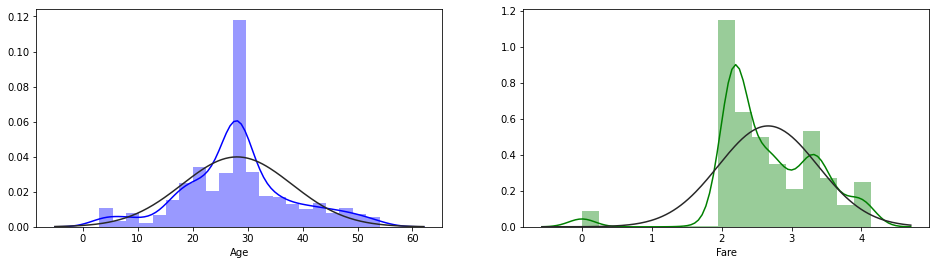

In [105]:
fig, ax = plt.subplots(1, 2 ,figsize = [16,4])
sns.distplot(ax = ax[0], a = train['Age'], color ='b', fit=norm)
sns.distplot(ax = ax[1], a = train['Fare'], color ='g',fit=norm)
plt.show()

In [106]:
#train.head()

In [107]:
#test.head()

On va alors effectuer 3 principales manipulations, utilisant 3 fonctions de la librairie de pré-processing de sklearn :
* `LabelEncoder` : qui permet, lorsqu'une variable est labellisée (avec des valeurs numériques) d'encoder cette labellisation pour qu'elle soit plus facile d'utilisation par un algorithme de Machine Learning;
* `One Hot Encoder` : technique découverte grâce à la réalisation de ce notebook, permet aussi de gérer les variables qualitatives d'une base de données, plus avec le lien suivant : https://kiwidamien.github.io/are-you-getting-burned-by-one-hot-encoding.html
* `StandardScaler` : qui permet de scaler les variables quantitatives, choses obligatoires lors du préprocessing.

In [108]:
le = LabelEncoder()
le.fit(train['Pclass'])
train['Pclass'] = le.transform(train['Pclass'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [109]:
#train.head()

In [110]:
ohe = OneHotEncoder(sparse = False, drop = 'first', categories = 'auto')
ohe.fit(train[['Sex', 'Embarked']])

ohecategory_train = ohe.transform(train[['Sex', 'Embarked']])
ohecategory_test = ohe.transform(test[['Sex', 'Embarked']])

for i in range(ohecategory_train.shape[1]):
    train['dummy_variable_' + str(i)] = ohecategory_train[:,i]

for i in range(ohecategory_test.shape[1]):
    test['dummy_variable_' + str(i)] = ohecategory_test[:,i]

print('Train shape :', train.shape)
print('Test shape :', test.shape)

Train shape : (718, 20)
Test shape : (418, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [111]:
#train.head()

In [112]:
# Scaling des données quantitatives

sc = StandardScaler()
sc.fit(train[['Age', 'SibSp', 'Parch', 'Fare']])
train[['Age', 'SibSp', 'Parch', 'Fare']] = sc.transform(train[['Age', 'SibSp', 'Parch', 'Fare']])
test[['Age', 'SibSp', 'Parch', 'Fare']] = sc.transform(test[['Age', 'SibSp', 'Parch', 'Fare']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [113]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,LastName,Train,FamilySurvived,FamilyDied,Size_Family,Title,dummy_variable_0,dummy_variable_1,dummy_variable_2
0,1,0,2,"Braund, Mr. Owen Harris",male,-0.607611,0.686268,-0.40491,A/5 21171,-0.779352,S,Braund,1,0,1,2,Mr,1.0,0.0,1.0
1,3,1,2,"Heikkinen, Miss. Laina",female,-0.207827,-0.484137,-0.40491,STON/O2. 3101282,-0.668797,S,Heikkinen,1,0,0,1,Miss,0.0,0.0,1.0
2,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.691688,0.686268,-0.40491,113803,1.864379,S,Futrelle,1,0,1,2,Mrs,0.0,0.0,1.0
3,5,0,2,"Allen, Mr. William Henry",male,0.691688,-0.484137,-0.40491,373450,-0.649245,S,Allen,1,0,0,1,Mr,1.0,0.0,1.0
4,6,0,2,"Moran, Mr. James",male,-0.007934,-0.484137,-0.40491,330877,-0.587211,Q,Moran,1,1,1,1,Mr,1.0,1.0,0.0


In [114]:
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,LastName,Train,FamilySurvived,FamilyDied,Size_Family,Title,dummy_variable_0,dummy_variable_1,dummy_variable_2
718,892,-1,3,"Kelly, Mr. James",male,0.641715,-0.484137,-0.404910,330911,-0.683968,Q,Kelly,0,3,1,1,Mr,1.0,1.0,0.0
719,893,-1,3,"Wilkes, Mrs. James (Ellen Needs)",female,1.891041,0.686268,-0.404910,363272,-0.822610,S,Wilkes,0,0,0,2,Mrs,0.0,0.0,1.0
720,894,-1,2,"Myles, Mr. Thomas Francis",male,3.390233,-0.484137,-0.404910,240276,-0.415451,Q,Myles,0,0,0,1,Mr,1.0,1.0,0.0
721,895,-1,3,"Wirz, Mr. Albert",male,-0.107881,-0.484137,-0.404910,315154,-0.557184,S,Wirz,0,0,0,1,Mr,1.0,0.0,1.0
722,896,-1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,-0.607611,0.686268,0.870202,3101298,-0.109345,S,Hirvonen,0,0,0,3,Mrs,0.0,0.0,1.0


# Modèle implémenté à la main

Il s'agit ici plus d'un petit jeu, mais à la vue des statistiques effectuées au début, il nous serait probablement possible d'écrire un modèle "à la main" de type decision tree, en appliquant juste un règle de "majorité".

## Les questions

On se propose donc d'élaborer une suite de questions, un peu comme Akinator, dans le but de prédire la surive (1) ou la mort (0) du passager :
On va en même temps réfléchir au "pire scénario" pour établir une baseline, un pire résultat, qui nous servira de borne inférieur pour la suite.

1. **Le passager était-il sur le Titanic ?** : Si oui, alors la majorité (62%) mourra. Si l'on suppose tout le monde mort, on a donc une précision de 62%.

2. **Le passager était-il un homme ou une femme** : Si homme, la majorité meurt (81 %). Si femme, la majorité survit (74%). la probabilité d'être juste (Bayes, etc...) est alors de 79%.

3. **Branche femme : La passagère était-elle en classe 1, 2 ou 3 ? (314 individus)** : plus de 90% de chances d'être correct dans les deux cas, on s'arrêtera donc là. (classe 3 est un 50/50).

4. **Branche femme, classe 3, ou la passagère embarquait-elle ? (144 individus)** : C et Q, la majorité survivent donc on n ne change pas, S en revanche, 63% meurts. On donnera donc 0 (died) pour le chemin [Yes -> Female -> 3 -> S]. On atteint alors une probabilité d'être juste de 80%.

5. **Branche femme, classe 3, embarqué à S (88 individus)** : Sur ces 88 individus, 55 sont morts, 33 ont survécus. On cherche donc, soit à trouver facilement les 33 survivants, ou bien un sous-groupe de ces 88 individus qu'on peut facilement changer de morts à survivants. Une possibilité concerne ceux ayant acheté un ticket entre 0\$ et 8\$ pour qui une majorité de ce sous-groupe a survécu. C'est une faible contribution qui amène la probabilité d'avoir raison à 8#%, mais pas forcément nécéssaire.

6. **Branche homme (544 individus)** : On va s'arrêter là, en supposant tous les hommes morts. En regardant rapidement on gagne très peu d'information à choisir le lieu d'embarquement ou la classe, et 81% est déjà assez raisonnable. La seule remarque qu'on fera, c'est que les hommes ayant le titre de "Master" ont une survie majoritaire (52%).

On a donc réussi à, selon Bayes, obtenir une probabilité d'être juste de 82% avec l'arbre ci dessus.

## Le modèle

On code donc le modèle décrit ci-dessus, avec le jeu de données pré-conversion (brutes), la conversion étant faite pour améliorer le score d'un point de vue de Machine Learning (et ne correspondant pas dutout avec nos condition.

In [115]:
def HandMade_Tree(df):
    
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master']

    for index, row in df.iterrows():

        # Q1
        Model.loc[index, 'Predict'] = 0

        # Q2
        if (df.loc[index, 'Sex'] == 'female'):
            Model.loc[index, 'Predict'] = 1

        # Q5      
        if ((df.loc[index, 'Sex'] == 'female') & (df.loc[index, 'Pclass'] == 3) & (df.loc[index, 'Embarked'] == 'S')  & (df.loc[index, 'Fare'] > 8)):
            Model.loc[index, 'Predict'] = 0

        # Q6
        if ((df.loc[index, 'Sex'] == 'male') & (df.loc[index, 'Title'] in male_title)):
            Model.loc[index, 'Predict'] = 1

    return Model

Tree_Predict = HandMade_Tree(data1)
print('Handmade tree model Accuracy/Precision : {:.2f}%\n'.format(metrics.accuracy_score(data1['Survived'], Tree_Predict)*100))
print(metrics.classification_report(data1['Survived'], Tree_Predict))

Handmade tree model Accuracy/Precision : 81.48%

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       478
           1       0.78      0.62      0.69       240

    accuracy                           0.81       718
   macro avg       0.80      0.77      0.78       718
weighted avg       0.81      0.81      0.81       718



In [116]:
predict_handmade = HandMade_Tree(data2)['Predict'].to_numpy().astype(int)

In [117]:
submission_handmade = pd.DataFrame()
submission_handmade['PassengerId'] = test_data['PassengerId']
submission_handmade['Survived'] = predict_handmade
submission_handmade['Survived'].value_counts()

0    277
1    141
Name: Survived, dtype: int64

In [118]:
submission_handmade.to_csv('submission_handmade.csv', index = False, header = True)

On a donc un score de 81.48% Sur ce modèle "fait main" (sur la base d'entrainement). On va le soumettre à Kaggle pour avoir une idée du score obtenu avec ce simple codage. On obtient un score de 0.76315 de réussite, pas si mal donc (TOP 78%), mais loin du haut du panier.

# Sélection de Variables

On a effectué un certain nombre de manipulations sur les variables dans la partie précédente, notamment au niveau de la création et du OHE, on va donc selectionner les varialbes qu'on juge pertinente pour notre modèle. Cette partie peut être modifiée pour observer l'impact sur la performance du choix de telle ou telle variable.

In [119]:
print('Train cols :\n',train.columns)
print('\n Train shape : ', train.shape)
print('\n')
print('Test cols :\n',test.columns)
print('\n Test shape : ', test.shape)

Train cols :
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'LastName', 'Train',
       'FamilySurvived', 'FamilyDied', 'Size_Family', 'Title',
       'dummy_variable_0', 'dummy_variable_1', 'dummy_variable_2'],
      dtype='object')

 Train shape :  (718, 20)


Test cols :
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'LastName', 'Train',
       'FamilySurvived', 'FamilyDied', 'Size_Family', 'Title',
       'dummy_variable_0', 'dummy_variable_1', 'dummy_variable_2'],
      dtype='object')

 Test shape :  (418, 20)


In [120]:
#train.head()

In [121]:
train.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked', 'LastName', 'Train', 'Title'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked', 'LastName', 'Train', 'Title'], axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [122]:
print('Train columns :\n',train.columns)
print('\n Train shape : ', train.shape)
print('\n')
print('Test columns :\n',test.columns)
print('\n Test shape : ', test.shape)

Train columns :
 Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySurvived',
       'FamilyDied', 'Size_Family', 'dummy_variable_0', 'dummy_variable_1',
       'dummy_variable_2'],
      dtype='object')

 Train shape :  (718, 12)


Test columns :
 Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySurvived',
       'FamilyDied', 'Size_Family', 'dummy_variable_0', 'dummy_variable_1',
       'dummy_variable_2'],
      dtype='object')

 Test shape :  (418, 12)


In [123]:
X_train = train.iloc[:, 1:].values
y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

#print('X_train :\n', X_train[0:5])
#print('y_train :\n', y_train[0:5])

# Modèles de Prédiction

Plusieurs modèles ont été testés et cette partie du notebook est probablement celle qui a subi le plus de modification. On a pour l'instant laissé le K-NN qui semble être le plus performant, ainsi qu'un SVC et un MLP (à peine tuné).

Cette partie sera ré-écrite pour revenir sur la méthode d'obtention du meilleur résultats, avec des cross-validations ainsi qu'une méthode comparative de modèles plus efficace.

In [124]:
clf = KNeighborsClassifier(leaf_size = 1, metric = 'minkowski', n_neighbors = 12, p = 1, weights = 'distance')
accuracies = cross_val_score(clf, X_train, y_train, cv = 20, verbose = 1)
print('Accuracies : ', accuracies)
print('AVG Accuracies : ', accuracies.mean())
print('STD/variance:',accuracies.std())

Accuracies :  [0.80555556 0.88888889 0.80555556 0.69444444 0.80555556 0.75
 0.66666667 0.86111111 0.94444444 0.80555556 0.80555556 0.86111111
 0.83333333 0.88888889 0.75       0.80555556 0.86111111 0.75
 0.8        0.88571429]
AVG Accuracies :  0.8134523809523809
STD/variance: 0.06682590345922641


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


In [125]:
other_clf = svm.SVC(kernel= "sigmoid", decision_function_shape= "ovr")
accuracies_other = cross_val_score(other_clf, X_train, y_train, cv = 32, verbose = 1)
print('Accuracies : ', accuracies_other)
print('AVG Accuracies : ', accuracies_other.mean())
print('STD/variance:',accuracies_other.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracies :  [0.60869565 0.65217391 0.7826087  0.7826087  0.65217391 0.65217391
 0.60869565 0.7826087  0.69565217 0.43478261 0.73913043 0.69565217
 0.69565217 0.82608696 0.5        0.63636364 0.63636364 0.72727273
 0.54545455 0.63636364 0.63636364 0.77272727 0.68181818 0.63636364
 0.59090909 0.68181818 0.77272727 0.63636364 0.77272727 0.5
 0.77272727 0.68181818]
AVG Accuracies :  0.6695899209486166
STD/variance: 0.09103847434457323


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


In [126]:
other_clf_2 = MLPClassifier(random_state = 1, max_iter= 1000, hidden_layer_sizes= (30, 30, 30 ,30, 30))
accuracies_other_2 = cross_val_score(other_clf_2, X_train, y_train, cv = 5)
print('Accuracies : ', accuracies_other_2)
print('AVG Accuracies : ', accuracies_other_2.mean())
print('STD/variance:',accuracies_other_2.std())

Accuracies :  [0.75694444 0.77777778 0.79861111 0.8041958  0.86013986]
AVG Accuracies :  0.7995337995337995
STD/variance: 0.034591495698090516


## Résultats et "Submission"

In [61]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred = y_pred.astype('int64')

submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = y_pred
submission['Survived'].value_counts()

0    286
1    132
Name: Survived, dtype: int64

In [62]:
#y_pred

In [63]:
submission.to_csv('submission_KNN.csv', index = False, header = True)

Cette soumission est la meilleure, elle nous donne un score de presque 80% de prédiction sur Kagge (0.79904) donnant un classement de de TOP 7% (au 21 aout 2020)